# LeNet

## 导入所需的module

+ torch

+ matplotlib

+ DataloadFasiionMNIST

In [1]:
import torch
from torch import nn, optim
import time
import matplotlib.pyplot as plt
from MODULE import DataloadFasionMNIST as dl

## Reshape类

+ 提供给神经网络的输入

+ 批量数不变，通道数为1，size为28\*28

In [2]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

## 卷积神经网络(LeNet)

+ 对输入进行reshape

+ 第一个卷积层（卷积+sigmoid激活+平均池化），将通道数扩展到6，激活层不变，池化层高和宽变到14\*14（提取信息分散到各个通道）

+ 第二个卷积层（卷积+sigmoid激活+平均池化），输入是6\*14\*14,经过激活和池化后输出变成16\*5\*5

+ 将高维张量展平

+ 全连接层（感知机）:将很长的张量慢慢向下压缩直到10

In [33]:
net = torch.nn.Sequential(Reshape(), 
                          nn.Conv2d(1, 6, kernel_size=5,padding=2), nn.Sigmoid(),nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),nn.AvgPool2d(kernel_size=2, stride=2), 
                          nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), 
                          nn.Linear(84, 10))

## 加载数据

In [34]:
batch_size = 256
train_iter, test_iter = dl.load_dataset(batch_size)

## 训练模型函数

+ 初始化权重策略:如果是全连接层或卷积层就用Xavier初始化权重(控制随机输入的方差稳定，防止模型一开始就遇到梯度爆炸等等问题)

+ 优化器策略:随机梯度下降SGD，也可以换别的

+ 量化损失策略:交叉熵(Cross Entropy)，也可以换MSE等等，在多类分类问题中交叉熵表现更好

+ 迭代训练:每次迭代对每个batch梯度设0，前向操作，计算loss，计算梯度，然后进入下一个迭代

+ 最后在测试集上评估模型

In [32]:
def train_LeNet(net, train_iter, test_iter, num_epochs, lr, device='cpu'):
    # 初始化权重
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    print('training on', device)
    net.to(device)
    
    # 优化器 -> SGD
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    # 损失函数 -> 交叉熵
    loss = nn.CrossEntropyLoss()
    
    # 记录每个epoch的损失和准确率
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    # 开始迭代
    for epoch in range(num_epochs):
        net.train()
        train_loss, train_acc, num_examples = 0.0, 0.0, 0
        start_time = time.time()
        
        # 训练阶段
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            
            train_loss += l.item() * X.size(0)
            train_acc += (y_hat.argmax(dim=1) == y).sum().item()
            num_examples += X.size(0)
        
        train_loss /= num_examples
        train_acc /= num_examples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # 评估阶段
        net.eval()
        test_acc, num_test_examples = 0.0, 0
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                test_acc += (y_hat.argmax(dim=1) == y).sum().item()
                num_test_examples += X.size(0)
        test_acc /= num_test_examples
        test_accuracies.append(test_acc)
        
        end_time = time.time()
        
        print(f'Epoch {epoch + 1}: '
              f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
              f'test acc {test_acc:.3f}, '
              f'time {(end_time - start_time):.2f} sec')
    
    print('Training complete')
    
    # 绘制图表
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 6))
    
    # 绘制训练损失
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    # 绘制训练准确率
    plt.plot(epochs, train_accuracies, 'go-', label='Train Accuracy')
    # 绘制测试准确率
    plt.plot(epochs, test_accuracies, 'ro-', label='Test Accuracy')
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss and Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

## 设定超参数并训练模型

training on cpu
Epoch 1: loss 2.321, train acc 0.099, test acc 0.100, time 4.68 sec
Epoch 2: loss 1.672, train acc 0.349, test acc 0.541, time 4.46 sec
Epoch 3: loss 0.905, train acc 0.642, test acc 0.677, time 4.43 sec
Epoch 4: loss 0.730, train acc 0.717, test acc 0.730, time 4.76 sec
Epoch 5: loss 0.652, train acc 0.747, test acc 0.715, time 4.62 sec
Epoch 6: loss 0.600, train acc 0.768, test acc 0.754, time 3.00 sec
Epoch 7: loss 0.557, train acc 0.788, test acc 0.774, time 5.14 sec
Epoch 8: loss 0.522, train acc 0.801, test acc 0.781, time 4.70 sec
Epoch 9: loss 0.496, train acc 0.812, test acc 0.809, time 4.89 sec
Epoch 10: loss 0.475, train acc 0.820, test acc 0.792, time 4.86 sec
Epoch 11: loss 0.451, train acc 0.831, test acc 0.805, time 4.51 sec
Epoch 12: loss 0.438, train acc 0.837, test acc 0.826, time 4.70 sec
Epoch 13: loss 0.423, train acc 0.844, test acc 0.836, time 3.16 sec
Epoch 14: loss 0.412, train acc 0.848, test acc 0.821, time 4.59 sec
Epoch 15: loss 0.403, train

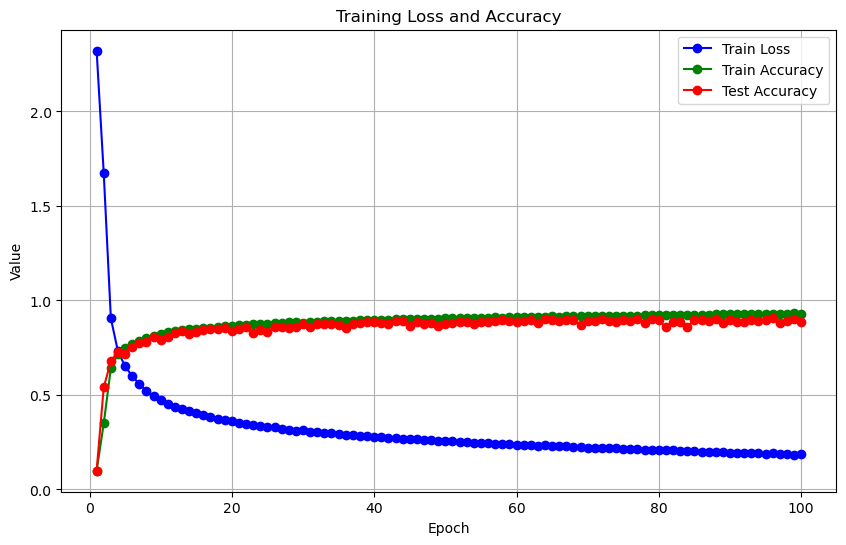

In [35]:
# baseline
epochs = 100
lr = 0.9
train_LeNet(net, train_iter, test_iter, epochs, lr)

## 自由调整模型

In [7]:
# 将第一次卷积直接从6通道转为10通道
net = torch.nn.Sequential(Reshape(), 
                          nn.Conv2d(1, 10, kernel_size=5,padding=2), nn.Sigmoid(),nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(10, 16, kernel_size=5), nn.Sigmoid(),nn.AvgPool2d(kernel_size=2, stride=2), 
                          nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), 
                          nn.Linear(84, 10))

In [37]:
# 在隐藏层中加速压缩
net = torch.nn.Sequential(Reshape(), 
                          nn.Conv2d(1, 10, kernel_size=5,padding=2), nn.Sigmoid(),nn.AvgPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(10, 16, kernel_size=5), nn.Sigmoid(),nn.AvgPool2d(kernel_size=2, stride=2), 
                          nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 64), nn.Sigmoid(), 
                          nn.Linear(64, 10))

In [25]:
# 将激活函数从sigmoid改为ReLU，将池化层从平均池化改为最大池化
net = torch.nn.Sequential(Reshape(), 
                          nn.Conv2d(1, 6, kernel_size=5,padding=2), nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2),
                          nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2), 
                          nn.Flatten(),
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), 
                          nn.Linear(84, 10))

# 数据挖掘调参

In [29]:
import torch.nn.functional as F


class ImprovedLeNet5(nn.Module):
    def __init__(self):
        super(ImprovedLeNet5, self).__init__()
        
        # 卷积层1
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)  # 1通道 -> 6通道
        self.bn1 = nn.BatchNorm2d(6)  # 批归一化
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化
        
        # 卷积层2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 6通道 -> 16通道
        self.bn2 = nn.BatchNorm2d(16)  # 批归一化
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 最大池化
        
        # 全连接层1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 16通道，5x5的特征图
        self.dropout1 = nn.Dropout(0.5)  # Dropout层
        self.fc2 = nn.Linear(120, 84)  # 120 -> 84
        self.dropout2 = nn.Dropout(0.5)  # Dropout层
        
        # 输出层
        self.fc3 = nn.Linear(84, 10)  # 84 -> 10（分类任务）
        
    def forward(self, x):
        # 卷积层1
        x = F.relu(self.bn1(self.conv1(x)))  # ReLU + 批归一化
        x = self.pool1(x)
        
        # 卷积层2
        x = F.relu(self.bn2(self.conv2(x)))  # ReLU + 批归一化
        x = self.pool2(x)
        
        # Flatten操作
        x = torch.flatten(x, 1)
        
        # 全连接层1
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        # 全连接层2
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # 输出层
        x = self.fc3(x)
        
        return x

# 实例化模型
net = ImprovedLeNet5()

training on cpu
Epoch 1: loss 0.971, train acc 0.641, test acc 0.785, time 5.28 sec
Epoch 2: loss 0.583, train acc 0.790, test acc 0.821, time 5.15 sec
Epoch 3: loss 0.502, train acc 0.825, test acc 0.814, time 5.33 sec
Epoch 4: loss 0.454, train acc 0.841, test acc 0.814, time 5.18 sec
Epoch 5: loss 0.425, train acc 0.854, test acc 0.810, time 5.26 sec
Epoch 6: loss 0.408, train acc 0.858, test acc 0.866, time 3.99 sec
Epoch 7: loss 0.391, train acc 0.865, test acc 0.867, time 5.84 sec
Epoch 8: loss 0.377, train acc 0.871, test acc 0.829, time 6.97 sec
Epoch 9: loss 0.366, train acc 0.874, test acc 0.882, time 6.45 sec
Epoch 10: loss 0.358, train acc 0.878, test acc 0.851, time 6.31 sec
Training complete


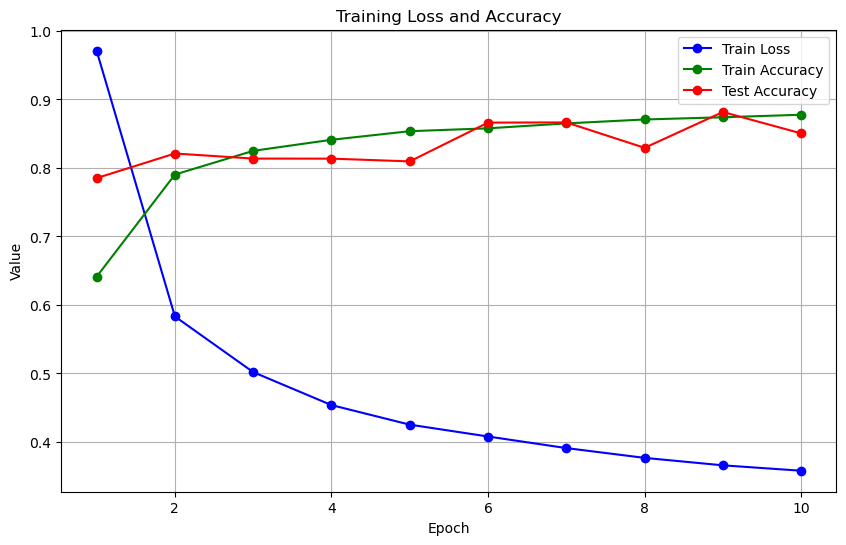

In [30]:
epochs = 10
lr = 0.9
train_LeNet(net, train_iter, test_iter, epochs, lr)

training on cpu
Epoch 1: loss 1.681, train acc 0.434, test acc 0.669, time 3.72 sec
Epoch 2: loss 0.629, train acc 0.757, test acc 0.769, time 5.34 sec
Epoch 3: loss 0.486, train acc 0.814, test acc 0.796, time 5.31 sec
Epoch 4: loss 0.419, train acc 0.840, test acc 0.832, time 5.12 sec
Epoch 5: loss 0.383, train acc 0.854, test acc 0.850, time 5.30 sec
Epoch 6: loss 0.363, train acc 0.863, test acc 0.818, time 5.13 sec
Epoch 7: loss 0.339, train acc 0.873, test acc 0.845, time 3.66 sec
Epoch 8: loss 0.325, train acc 0.878, test acc 0.846, time 5.12 sec
Epoch 9: loss 0.312, train acc 0.883, test acc 0.854, time 5.28 sec
Epoch 10: loss 0.298, train acc 0.889, test acc 0.871, time 5.21 sec
Training complete


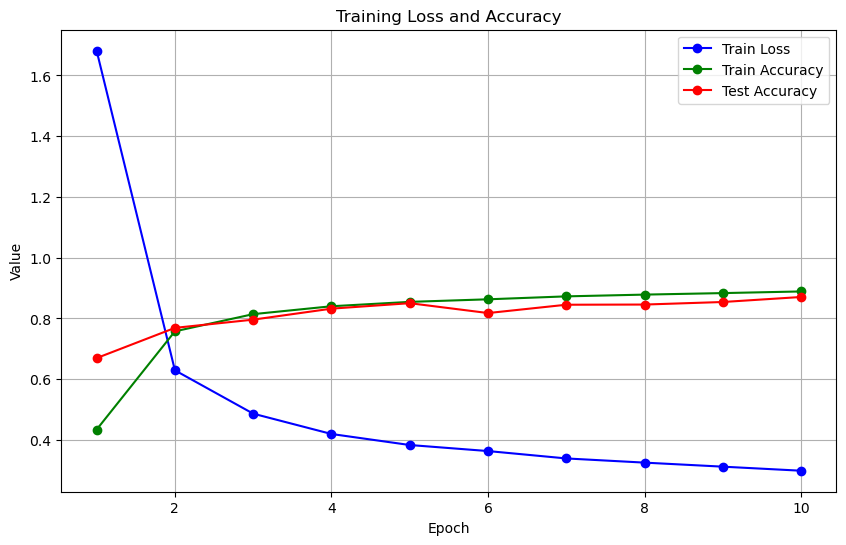

In [31]:
net = nn.Sequential(
    # 第一层：卷积 + BatchNorm + ReLU + MaxPool
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.BatchNorm2d(6),  # 批归一化
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # 第二层：卷积 + BatchNorm + ReLU + MaxPool
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),  # 批归一化
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # 展开层
    nn.Flatten(),

    # 全连接层
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),

    # 第二个全连接层
    nn.Linear(120, 84),
    nn.ReLU(),

    # 输出层
    nn.Linear(84, 10)
)
epochs = 10
lr = 0.9
train_LeNet(net, train_iter, test_iter, epochs, lr)